## Dataset

In [21]:
!wget "http://www.vision.ee.ethz.ch/ntire18/o-haze/O-HAZE.zip"

--2021-09-07 19:23:28--  http://www.vision.ee.ethz.ch/ntire18/o-haze/O-HAZE.zip
Resolving www.vision.ee.ethz.ch (www.vision.ee.ethz.ch)... 129.132.19.216, 2001:67c:10ec:254::216
Connecting to www.vision.ee.ethz.ch (www.vision.ee.ethz.ch)|129.132.19.216|:80... connected.
HTTP request sent, awaiting response... 301 
Location: https://data.vision.ee.ethz.ch/cvl/ntire18//o-haze/O-HAZE.zip [following]
--2021-09-07 19:23:28--  https://data.vision.ee.ethz.ch/cvl/ntire18//o-haze/O-HAZE.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 573320339 (547M) [application/zip]
Saving to: ‘O-HAZE.zip’

O-HAZE.zip          100%[===================>] 546.76M  24.9MB/s    in 23s     

2021-09-07 19:23:52 (23.7 MB/s) - ‘O-HAZE.zip’ saved [573320339/573320339]



In [22]:
!unzip "/content/O-HAZE.zip"

Archive:  /content/O-HAZE.zip
   creating: # O-HAZY NTIRE 2018/
   creating: # O-HAZY NTIRE 2018/GT/
 extracting: # O-HAZY NTIRE 2018/GT/01_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/02_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/03_outdoor_GT.JPG  
  inflating: # O-HAZY NTIRE 2018/GT/04_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/05_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/06_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/07_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/08_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/09_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/10_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/11_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/12_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/13_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/14_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/15_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/16_outdoor_GT.jpg  
 ex

In [2]:
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm 
import glob
import torch.nn as nn
import torch
from tqdm.auto import tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgYNJQcxDoGVW_LSkj1-0syAifCt64vmswAXfHntlBMr4aqmamBri8
Mounted at /content/drive


In [4]:
def make_tile(image_path, path_to_save, patch_size=32):

  img = Image.open(image_path)
  image_name = image_path.split("/")[-1].split(".")[0]

  if not os.path.exists(os.path.join(path_to_save, image_name)):
    os.mkdir(os.path.join(path_to_save, image_name))

  tiles = 0
  
  for w in range(0, img.size[0], patch_size):
    
    for h in range(0, img.size[1], patch_size):
      
      w_end = w + patch_size
      h_end = h + patch_size

      cropped = np.array(img)[h: h_end, w: w_end]

      if cropped.shape != (patch_size, patch_size, 3):
        continue
      
      path_to_save_image = os.path.join(path_to_save, image_name, "{}_tiles_{}.jpg".format(image_name, tiles))
      Image.fromarray(cropped).save(path_to_save_image)

      tiles += 1


In [ ]:
# for image_path in tqdm(glob.glob("/content/# O-HAZY NTIRE 2018/GT/*")):
#   make_tile(image_path, "/content/drive/MyDrive/hazy_dataset/GT")

In [ ]:
# !rm -r "/content/drive/MyDrive/hazy_dataset/GT/01_outdoor_GT"

In [ ]:
GT_extracted = ["06", "14", "15", "19", "21", "29", "30", "33", "35", "37", "40", "42", "45"]

In [ ]:
hazy_path = glob.glob("/content/# O-HAZY NTIRE 2018/hazy/*")
hazy_path = list(filter(lambda x: str(x.split("/")[-1][:2]) in GT_extracted, hazy_path))
hazy_path

['/content/# O-HAZY NTIRE 2018/hazy/15_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/14_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/35_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/30_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/06_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/19_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/45_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/21_outdoor_hazy.JPG',
 '/content/# O-HAZY NTIRE 2018/hazy/40_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/29_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/37_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/33_outdoor_hazy.jpg',
 '/content/# O-HAZY NTIRE 2018/hazy/42_outdoor_hazy.jpg']

In [ ]:
# for image_path in tqdm(hazy_path):
#   make_tile(image_path, "/content/drive/MyDrive/hazy_dataset/hazy")

In [ ]:
len(glob.glob("/content/drive/MyDrive/hazy_dataset/hazy/40_outdoor_hazy/*"))

11445

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
gen_lr = 2e-5
disc_lr = 4e-5
batch_size=32
device
patch_size=32

## DataLoader

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

In [6]:
class patch_dataset(Dataset):

  def __init__(self, dataset_root, transforms=None):
    
    self.transforms = transforms

    GT_path = os.path.join(dataset_root, "GT")
    hazy_path = os.path.join(dataset_root, "hazy")

    self.pairs = []

    for folder in tqdm(os.listdir(GT_path)):

      for image_name in os.listdir(os.path.join(GT_path, folder)):
        
        hazy_image_name = image_name.split(".")[0].split("_")
        hazy_image_name[2] = "hazy"
        hazy_image_name = "_".join(hazy_image_name)
        hazy_image_name = hazy_image_name + ".jpg"

        folder_hazy = folder.split("_")
        folder_hazy[2] = "hazy"
        folder_hazy = "_".join(folder_hazy)
        

        hazy = os.path.join(hazy_path, folder_hazy, hazy_image_name)
        gt = os.path.join(GT_path, folder, image_name)

        self.pairs.append((hazy, gt))
      

  def __getitem__(self, index):
    
    haze_path, gt_path = self.pairs[index]

    hazed_image = np.array(Image.open(haze_path))
    hazed_image = hazed_image[:, :, 0] # Red Channel
    hazed_image = Image.fromarray(hazed_image)

    gt_image = np.array(Image.open(gt_path))
    gt_image = gt_image[:, :, 0] # Red Channel
    gt_image = Image.fromarray(gt_image)

    
    if self.transforms != None :
      hazed_image = self.transforms(hazed_image)
      gt_image = self.transforms(gt_image)

    
    return (hazed_image, gt_image)
    
  
  def __len__(self):
    return len(self.pairs)

In [7]:
dataset = patch_dataset("/content/drive/MyDrive/hazy_dataset/", transform)

  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
dataset[0][0].shape

torch.Size([1, 32, 32])

In [9]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Generator and Discriminator

In [10]:
# gen = nn.Sequential(
#     nn.ConvTranspose2d(3, 128, 3),
#     nn.ReLU(),

#     nn.ConvTranspose2d(128, 128, 3),
#     nn.ReLU(),

#     nn.ConvTranspose2d(128, 128, 3),
#     nn.ReLU(),

#     nn.ConvTranspose2d(128, 64, 3),
#     nn.ReLU(),

#     nn.ConvTranspose2d(64, 32, 3),
#     nn.ReLU(),

#     nn.Conv2d(32, 3, 3),
#     nn.ReLU(),

#     nn.Conv2d(3, 3, 3),
#     nn.ReLU(),


#     nn.Conv2d(3, 3, 3),
#     nn.ReLU(),

#     nn.Conv2d(3, 3, 3),
#     nn.ReLU(),

#     nn.Conv2d(3, 3, 3),
#     nn.ReLU(),

# )

gen = nn.Sequential(
    nn.Conv2d(1, 128, 3, padding="same"),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 128, 3, padding="same"),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 64, 3, padding="same"),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 1, 3, padding="same"),
    nn.Tanh(),
)

In [11]:
x = torch.randn(1, 1, 32, 32)
gen(x).shape

torch.Size([1, 1, 32, 32])

In [12]:
disc = nn.Sequential(
    nn.Conv2d(1, 16, 3),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.18),

    nn.Conv2d(16, 32, 5),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.18),

    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.18),

    nn.Flatten(),

    nn.Linear(64 * 24 * 24, 1)
)

In [13]:
x = torch.randn(10, 1, 32, 32)
disc(x).shape

torch.Size([10, 1])

## Loss

In [14]:
criterion = nn.BCEWithLogitsLoss()
disc_optim = torch.optim.AdamW(disc.parameters(), lr=disc_lr, betas=(0.3, 0.999), weight_decay=1e-2)
gen_optim = torch.optim.AdamW(gen.parameters(), lr=gen_lr, betas=(0.3, 0.999), weight_decay=1e-2)

In [15]:
checkpoint = torch.load("/content/drive/MyDrive/dehazing_checkpoints/ckpt_epoch_1_iter_1341.pth")
gen.load_state_dict(checkpoint["generator_state_dict"])
gen_optim.load_state_dict(checkpoint["generator_optimizer_dict"])
disc.load_state_dict(checkpoint["discriminator_state_dict"])
disc_optim.load_state_dict(checkpoint["disc_optimizer_dict"])

In [16]:
def gen_loss(gen, disc, hazed_images, device):

  gen_out = gen(hazed_images)
  disc_out = disc(gen_out)

  loss = criterion(disc_out, torch.ones_like(disc_out))

  return loss

In [17]:
def disc_loss(gen, disc, hazed_images, gt_images, device):

  gen_out_fake = gen(hazed_images).detach()
  disc_out_fake = disc(gen_out_fake)
  fake_loss = criterion(disc_out_fake, torch.zeros_like(disc_out_fake))

  disc_out_real = disc(gt_images)
  real_loss = criterion(disc_out_real, torch.ones_like(disc_out_real))

  loss = 1/2 * (fake_loss + real_loss)

  return loss

## Training

In [18]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32)):
  
  image_tensor = (image_tensor + 1) / 2 # between 0 and 1 
  image_tensor = image_tensor.cpu().detach()

  image_grid = make_grid(image_tensor[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()


In [ ]:
# X, y = next(iter(train_loader))
# show_tensor_images(X)
# show_tensor_images(y)

In [19]:
def test_gen(gen, epoch, iteration):
  image_hazy = Image.open("/content/# O-HAZY NTIRE 2018/hazy/02_outdoor_hazy.jpg")
  width, height = image_hazy.size
  image_hazy = image_hazy.resize((width // 8, height // 8))
  image_hazy = np.array(image_hazy)[:, :, 0]

  # plt.imshow(image_hazy, cmap="gray")

  image_dehazed = np.zeros_like(image_hazy)

  for w in range(0, image_hazy.shape[1], patch_size):
    
    for h in range(0, image_hazy.shape[0], patch_size):
    
      h_end = h + patch_size
      w_end = w + patch_size

      patch = image_hazy[h: h_end, w: w_end]

      if patch.shape != (patch_size, patch_size):
        continue

      patch = transform(patch)

      # plt.figure()
      # plt.imshow(patch[0], cmap="gray")
      
      patch = patch.unsqueeze(dim = 0)
      dehazed = (gen(patch) + 1) / 2
      dehazed = dehazed.cpu().detach().squeeze().numpy()


      image_dehazed[h: h_end, w: w_end] = dehazed * 255
  
  plt.imshow(image_dehazed, cmap="gray")
  plt.savefig("/content/drive/MyDrive/dehazing_output/epoch_{}_iteration_{}".format(epoch, iteration))
  plt.show()


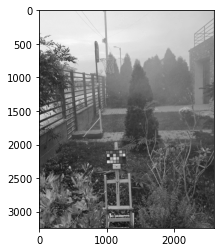

  0%|          | 0/4040 [00:00<?, ?it/s]

generator loss :  0.96645
discriminator loss :  0.59462


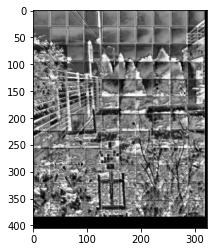

generator loss :  1.09817
discriminator loss :  0.54819


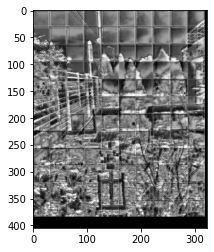

In [ ]:
cur_step = 0

plt.imshow(np.array(Image.open("/content/# O-HAZY NTIRE 2018/hazy/02_outdoor_hazy.jpg"))[:, :, 0], cmap="gray")
plt.show()

for epoch in range(5):
  
  for iteration, (X, y) in enumerate(tqdm(train_loader)):

    ## training generator
    gen_optim.zero_grad()
    g_loss = gen_loss(gen, disc, X, device)
    g_loss.backward()
    gen_optim.step()


    ## training discriminator

    disc_optim.zero_grad()
    d_loss = disc_loss(gen, disc, X, y, device)
    d_loss.backward()
    disc_optim.step()



    if iteration % 200 == 0:
      print("generator loss : ", np.round(g_loss.item(), 5))
      print("discriminator loss : ", np.round(d_loss.item(), 5))

      with torch.no_grad():
        
        # X, y = next(iter(train_loader))
        # gen_out_test = gen(X)
        # show_tensor_images(X, num_images=1)
        test_gen(gen, epoch, iteration)

        torch.save({
            "generator_state_dict": gen.state_dict(),
            "generator_optimizer_dict": gen_optim.state_dict(),
            "discriminator_state_dict": disc.state_dict(),
            "disc_optimizer_dict": disc_optim.state_dict(),
        }, "/content/drive/MyDrive/dehazing_checkpoints/ckpt_epoch_{}_iter_{}.pth".format(epoch, iteration))
        
       

    cur_step += 1 


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


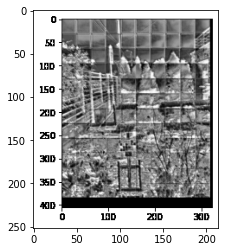

In [ ]:
hazed_image = np.array(Image.open("/content/step1400.png"))
hazed_image = hazed_image[:, :, 0] # Red Channel
plt.imshow(hazed_image, cmap="gray")
print(hazed_image)
hazed_image = 255 - hazed_image
hazed_image = Image.fromarray(hazed_image)

# tr = transform(hazed_image)

# tr = (tr + 1 ) / 2

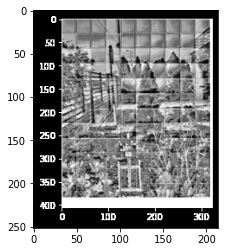

In [ ]:

plt.imshow(hazed_image, cmap="gray")